## Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Unzipping the data folder

In [ ]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/smai_a4/double_mnist.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")

!rm -rf /content/__MACOSX

## Solving fragmentation issue for memory

In [ ]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

## Imports

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import os
import sys
import cv2
import matplotlib.pyplot as plt
import time

## Function to plot graph

In [ ]:
def plot_loss_graph(train_loss_arr, val_loss_arr, save_as=None):
    # Plot the train loss and validation loss graph and save it to drive
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss_arr, label='Training Loss', color='blue', marker='o')
    plt.plot(val_loss_arr, label='Validation Loss', color='orange', marker='o')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')

    plt.legend()
    if save_as is None:
        plt.show()
    else:
        plt.savefig(save_as)

## DataLoader Class

In [ ]:
class MultiMNISTDataset:
    def __init__(self, data, labels, batch_size=32, shuffle=True, task="classification"):
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.data))  # Track the indexes for shuffling
        self.current_index = 0
        self.task = task

        if self.shuffle:
            self._shuffle_data()

    def _shuffle_data(self):
        np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __iter__(self):
        self.current_index = 0
        if self.shuffle:
            self._shuffle_data()
        return self

    def __next__(self):
        if self.current_index >= len(self.data):
            raise StopIteration

        # Compute the indices of the current batch
        start_idx = self.current_index
        end_idx = min(start_idx + self.batch_size, len(self.data))

        # Fetch the batch data and labels
        batch_indexes = self.indexes[start_idx:end_idx]
        batch_data = self.data[batch_indexes]
        batch_labels = self.labels[batch_indexes]

        # Update the current index
        self.current_index = end_idx

        # Convert NumPy arrays to PyTorch tensors
        batch_data_tensor = torch.from_numpy(batch_data).float()
        if self.task == "classification":
            batch_labels_tensor = torch.from_numpy(batch_labels).long()
        elif self.task == "regression":
            batch_labels_tensor = torch.from_numpy(batch_labels).float()

        return batch_data_tensor.unsqueeze(1), batch_labels_tensor

class MultiLabelCNN(nn.Module):
    def __init__(self, act_func: str, lr: float, dropout: float, optimiser: str):
        super(MultiLabelCNN, self).__init__()

        self.loss = nn.BCEWithLogitsLoss()

        if act_func == 'relu':
            self.activation = torch.relu
        elif act_func == 'sigmoid':
            self.activation = torch.sigmoid
        elif act_func == 'tanh':
            self.activation = torch.tanh
        else:
            raise ValueError('Activation function not supported.')

        self.lr = lr
        self.dropout = dropout
        self.op = optimiser

        # Defining Layers, Input is 128x128x1 images
        self.conv1 = nn.Conv2d(1, 64, 5)
        self.maxpool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, 5)
        self.maxpool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128*29*29, 1024)
        self.fc2 = nn.Linear(1024, 33)

    def forward(self, x):
        x = self.maxpool1(self.activation(self.conv1(x)))
        x = self.maxpool2(self.activation(self.conv2(x)))
        x = x.view(-1, 128*29*29)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

    def train_model(self, x, y, val_x, val_y, epochs, batch_size=32):
        self.batch_size = batch_size
        torch.cuda.empty_cache()
        if self.op == 'adam':
            self.optimiser = torch.optim.Adam(self.parameters(), lr=self.lr)
        elif self.op == 'sgd':
            self.optimiser = torch.optim.SGD(self.parameters(), lr=self.lr)
        else:
            raise ValueError('Optimiser not supported.')

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        train_dataloader = MultiMNISTDataset(x, y, batch_size=batch_size, task="regression")
        val_dataloader = MultiMNISTDataset(val_x, val_y, batch_size=batch_size, task="regression")

        train_loss_arr = list()
        val_loss_arr = list()

        train_iters = len(train_dataloader)
        val_iters = len(val_dataloader)

        for epoch in range(epochs):
            total_train_loss = 0
            total_val_loss = 0

            # Switching model to training mode
            self.train()

            for i, (images, labels) in enumerate(train_dataloader):
                train_images = images.to(device)
                train_labels = labels.to(device)

                # Forward Pass
                train_outputs = self.forward(train_images)
                train_loss = self.loss(train_outputs, train_labels)
                total_train_loss += train_loss.item()

                # Backward Pass
                self.optimiser.zero_grad()
                train_loss.backward()
                self.optimiser.step()
                print(f'Epoch {epoch+1}/{epochs}, iter [{i+1}/{train_iters}], Loss: {train_loss.item()}')
            avg_train_loss = total_train_loss / train_iters
            train_loss_arr.append(avg_train_loss)

            # Switching model to evaluation mode
            self.eval()

            # Calculating validation loss
            with torch.no_grad():
                for i, (val_images, val_labels) in enumerate(val_dataloader):
                    val_images = val_images.to(device)
                    val_labels = val_labels.to(device)
                    val_outputs = self.forward(val_images)
                    val_loss = self.loss(val_outputs, val_labels).item()
                    total_val_loss += val_loss
                avg_val_loss = total_val_loss / val_iters
                val_loss_arr.append(avg_val_loss)

        return train_loss_arr, val_loss_arr

    def accuracy(self, x, y, threshold=0.5):
        self.eval()
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        dataloader = MultiMNISTDataset(x, y, batch_size=self.batch_size, task="regression")

        exact_match_correct = 0
        hamming_correct = 0
        total_samples = 0
        total_labels = 0

        with torch.no_grad():
            for images, labels in dataloader:
                images = images.to(device)
                labels = labels.to(device).float()  # Ensure labels are in float for multi-label

                # Forward pass
                outputs = self.forward(images)
                predictions = torch.sigmoid(outputs) > threshold  # Apply sigmoid and threshold

                # Exact Match Accuracy
                exact_match_correct += (predictions == labels).all(dim=1).sum().item()  # Count where all labels match per sample
                total_samples += labels.size(0)  # Number of samples

                # Hamming Accuracy
                hamming_correct += (predictions == labels).sum().item()  # Count matches across all labels
                total_labels += labels.numel()  # Total number of labels across all samples

        exact_match_accuracy = exact_match_correct / total_samples if total_samples > 0 else 0
        hamming_accuracy = hamming_correct / total_labels if total_labels > 0 else 0

        return exact_match_accuracy, hamming_accuracy


    def get_loss(self, x, y):
        self.eval()
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        dataloader = MultiMNISTDataset(x, y, batch_size=self.batch_size, task="regression")
        iters = len(dataloader)
        with torch.no_grad():
            total_loss = 0
            for images, labels in dataloader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = self.forward(images)
                total_loss += self.loss(outputs, labels).item()
        return total_loss / iters

### The model requires an additional activation function of softmax after the last linear layer to convert the output logits to probabilities. I have choosen the loss function as nn.BCEWithLogitsLoss(). Using BCEWithLogitsLoss allows you to skip applying sigmoid in the final layer since it combines sigmoid activation and binary cross-entropy in a single, numerically stable operation.

## Function to Load data

In [ ]:
def load_mnist_data(base_dir_path, classification_type="single"):
    def load_data_for_folder(dir_path):
        images = []
        labels = []

        # Get all subdirectories
        dirs = [f for f in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, f))]
        # Iterate over all subdirectories
        for sub_dir in dirs:
            if classification_type == "multi":
                label = sub_dir
            else:
                label = len(sub_dir)
            sub_dir_path = dir_path + "/" + sub_dir
            # Get all image file names in the subdirectory
            img_files = [f for f in os.listdir(sub_dir_path) if os.path.isfile(os.path.join(sub_dir_path, f))]
            # Iterate over all images and read them
            for file in img_files:
                file_path = sub_dir_path + "/" + file
                img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                images.append(img)
                labels.append(label)

        images = np.array(images)
        labels = np.array(labels)
        return images, labels

    # Loading train data
    train_data_dir = base_dir_path + "/train"
    train_images, train_labels = load_data_for_folder(train_data_dir)

    # Loading test data
    test_data_dir = base_dir_path + "/test"
    test_images, test_labels = load_data_for_folder(test_data_dir)

    # Loading val data
    val_data_dir = base_dir_path + "/val"
    val_images, val_labels = load_data_for_folder(val_data_dir)

    return train_images, train_labels, test_images, test_labels, val_images, val_labels

## One Hot Encoding Function

In [ ]:
def one_hot_encode(labels):
    one_hot_encoded = np.zeros((len(labels), 33), dtype=int)

    for i, label in enumerate(labels):
        for j, char in enumerate(label):
            one_hot_encoded[i, j * 11 + int(char)] = 1

        for k in range(len(label), 3):
            one_hot_encoded[i, k * 11 + 10] = 1

    return one_hot_encoded

## Printing Data shape and statistics

In [ ]:
train_images, train_labels, test_images, test_labels, val_images, val_labels = load_mnist_data("/content/double_mnist", "multi")
print("Loaded MNIST data!")
print("Train data shape:", train_images.shape)
print("Test data shape:", test_images.shape)
print("Val data shape:", val_images.shape)
print("Train label shape:", train_labels.shape)
print("Test label shape:", test_labels.shape)
print("Val label shape:", val_labels.shape)
print()
print("One hot encoding the labels...")
print()
train_labels = one_hot_encode(train_labels)
test_labels = one_hot_encode(test_labels)
val_labels = one_hot_encode(val_labels)
print("Train label shape after one hot encoding:", train_labels.shape)
print("Test label shape after one hot encoding:", test_labels.shape)
print("Val label shape after one hot encoding:", val_labels.shape)

Loaded MNIST data!
Train data shape: (12600, 128, 128)
Test data shape: (4600, 128, 128)
Val data shape: (3000, 128, 128)
Train label shape: (12600,)
Test label shape: (4600,)
Val label shape: (3000,)

One hot encoding the labels...

Train label shape after one hot encoding: (12600, 33)
Test label shape after one hot encoding: (4600, 33)
Val label shape after one hot encoding: (3000, 33)


## Selecting Device and Epochs

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_epochs = 10

print("Device:", device)

Device: cuda


## Defining Hyperparameters for 5 classification models

In [ ]:
model_hyperparams = [
    {
        "task": "multi_label_classification",
        "act_func": "sigmoid",
        "lr": 0.001,
        "dropout": 0.5,
        "optimiser": "sgd",
        "model_name": "1"
    },
    {
        "task": "multi_label_classification",
        "act_func": "relu",
        "lr": 0.001,
        "dropout": 0.8,
        "optimiser": "sgd",
        "model_name": "2"
    },
    {
        "task": "multi_label_classification",
        "act_func": "relu",
        "lr": 0.001,
        "dropout": 0.5,
        "optimiser": "adam",
        "model_name": "3"
    },
    {
        "task": "multi_label_classification",
        "act_func": "sigmoid",
        "lr": 0.01,
        "dropout": 0.5,
        "optimiser": "adam",
        "model_name": "4"
    },
    {
        "task": "multi_label_classification",
        "act_func": "tanh",
        "lr": 0.001,
        "dropout": 0.5,
        "optimiser": "sgd",
        "model_name": "5"
    },
]

## Classification Model 1

Training started of Model 1, with parameters:
{'task': 'multi_label_classification', 'act_func': 'sigmoid', 'lr': 0.001, 'dropout': 0.5, 'optimiser': 'sgd', 'model_name': '1'}
Epoch 1/10, iter [1/394], Loss: 0.7139551639556885
Epoch 1/10, iter [2/394], Loss: 0.7056825757026672
Epoch 1/10, iter [3/394], Loss: 0.702446460723877
Epoch 1/10, iter [4/394], Loss: 0.698390781879425
Epoch 1/10, iter [5/394], Loss: 0.6935722231864929
Epoch 1/10, iter [6/394], Loss: 0.6833751797676086
Epoch 1/10, iter [7/394], Loss: 0.686549723148346
Epoch 1/10, iter [8/394], Loss: 0.678377091884613
Epoch 1/10, iter [9/394], Loss: 0.673656165599823
Epoch 1/10, iter [10/394], Loss: 0.668815016746521
Epoch 1/10, iter [11/394], Loss: 0.6619774103164673
Epoch 1/10, iter [12/394], Loss: 0.6560391783714294
Epoch 1/10, iter [13/394], Loss: 0.6584861278533936
Epoch 1/10, iter [14/394], Loss: 0.6518548130989075
Epoch 1/10, iter [15/394], Loss: 0.6484718322753906
Epoch 1/10, iter [16/394], Loss: 0.6420045495033264
Epoch 1

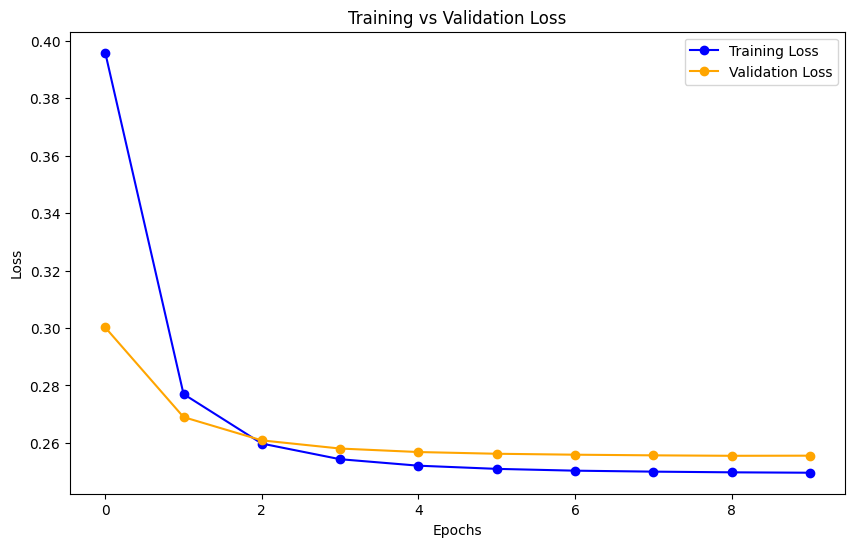

In [ ]:
# Extracting model 1 hyper-parameters
model_num = 1
hyperparams = model_hyperparams[model_num - 1]

# Training the model
model = MultiLabelCNN(act_func=hyperparams["act_func"], lr=hyperparams["lr"], dropout=hyperparams["dropout"], optimiser=hyperparams["optimiser"]).to(device)
print(f"Training started of Model {hyperparams['model_name']}, with parameters:\n{hyperparams}")
start_time = time.time()
train_loss_arr, val_loss_arr = model.train_model(train_images, train_labels, val_images, val_labels, n_epochs)
end_time = time.time()
print("\nTraining Complete, time taken:", end_time - start_time)
exact_match_acc, hamming_acc = model.accuracy(test_images, test_labels)
print(f"Exact Match Accuracy: {round(exact_match_acc * 100, 3)}%, Hamming Accuracy: {round(hamming_acc * 100, 3)}%")

# Plotting loss graph
plot_loss_graph(train_loss_arr, val_loss_arr, f"/content/drive/MyDrive/smai_a4/figures/{hyperparams['task']}/model_{hyperparams['model_name']}_loss.png")

# Saving the model
torch.save(model.state_dict(), f"/content/drive/MyDrive/smai_a4/saved_models/{hyperparams['task']}/model_{hyperparams['model_name']}.pth")
print(f"Saved {hyperparams['task']} model {hyperparams['model_name']}")

## Classification Model 2

Training started of Model 2, with parameters:
{'task': 'multi_label_classification', 'act_func': 'relu', 'lr': 0.001, 'dropout': 0.8, 'optimiser': 'sgd', 'model_name': '2'}
Epoch 1/10, iter [1/394], Loss: 1.0972318649291992
Epoch 1/10, iter [2/394], Loss: 0.6231428384780884
Epoch 1/10, iter [3/394], Loss: 0.5091618895530701
Epoch 1/10, iter [4/394], Loss: 0.45877403020858765
Epoch 1/10, iter [5/394], Loss: 0.4265821874141693
Epoch 1/10, iter [6/394], Loss: 0.40678051114082336
Epoch 1/10, iter [7/394], Loss: 0.4254235625267029
Epoch 1/10, iter [8/394], Loss: 0.3646184206008911
Epoch 1/10, iter [9/394], Loss: 0.3859720528125763
Epoch 1/10, iter [10/394], Loss: 0.33618584275245667
Epoch 1/10, iter [11/394], Loss: 0.3417719304561615
Epoch 1/10, iter [12/394], Loss: 0.3429828882217407
Epoch 1/10, iter [13/394], Loss: 0.37648114562034607
Epoch 1/10, iter [14/394], Loss: 0.3583223819732666
Epoch 1/10, iter [15/394], Loss: 0.3389112949371338
Epoch 1/10, iter [16/394], Loss: 0.3682299554347992


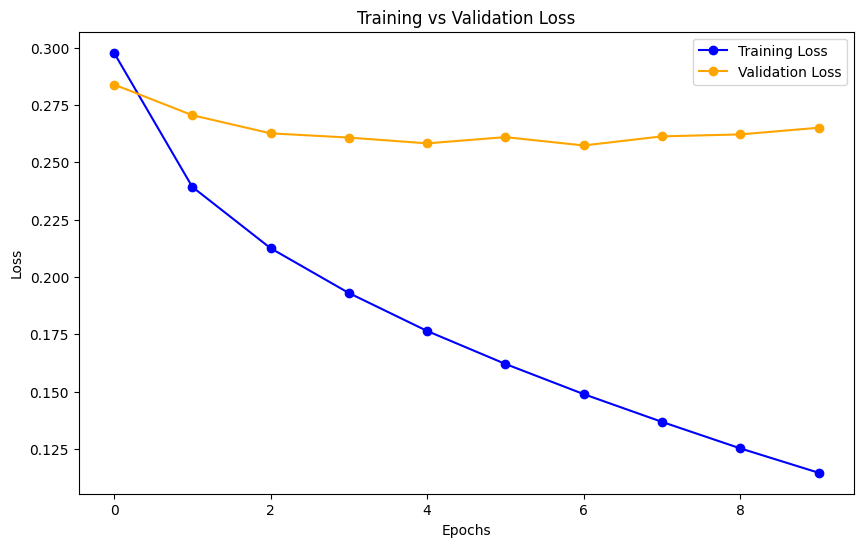

In [ ]:
# Extracting model 2 hyper-parameters
model_num = 2
hyperparams = model_hyperparams[model_num - 1]

# Training the model
model = MultiLabelCNN(act_func=hyperparams["act_func"], lr=hyperparams["lr"], dropout=hyperparams["dropout"], optimiser=hyperparams["optimiser"]).to(device)
print(f"Training started of Model {hyperparams['model_name']}, with parameters:\n{hyperparams}")
start_time = time.time()
train_loss_arr, val_loss_arr = model.train_model(train_images, train_labels, val_images, val_labels, n_epochs)
end_time = time.time()
print("\nTraining Complete, time taken:", end_time - start_time)
exact_match_acc, hamming_acc = model.accuracy(test_images, test_labels)
print(f"Exact Match Accuracy: {round(exact_match_acc * 100, 3)}%, Hamming Accuracy: {round(hamming_acc * 100, 3)}%")

# Plotting loss graph
plot_loss_graph(train_loss_arr, val_loss_arr, f"/content/drive/MyDrive/smai_a4/figures/{hyperparams['task']}/model_{hyperparams['model_name']}_loss.png")

# Saving the model
torch.save(model.state_dict(), f"/content/drive/MyDrive/smai_a4/saved_models/{hyperparams['task']}/model_{hyperparams['model_name']}.pth")
print(f"Saved {hyperparams['task']} model {hyperparams['model_name']}")

## Classification Model 3

Training started of Model 3, with parameters:
{'task': 'multi_label_classification', 'act_func': 'relu', 'lr': 0.001, 'dropout': 0.5, 'optimiser': 'adam', 'model_name': '3'}
Epoch 1/10, iter [1/394], Loss: 0.971018373966217
Epoch 1/10, iter [2/394], Loss: 8.812710762023926
Epoch 1/10, iter [3/394], Loss: 2.441253662109375
Epoch 1/10, iter [4/394], Loss: 0.9159490466117859
Epoch 1/10, iter [5/394], Loss: 0.47716808319091797
Epoch 1/10, iter [6/394], Loss: 0.5291407108306885
Epoch 1/10, iter [7/394], Loss: 0.5996752381324768
Epoch 1/10, iter [8/394], Loss: 0.6321244835853577
Epoch 1/10, iter [9/394], Loss: 0.6235609650611877
Epoch 1/10, iter [10/394], Loss: 0.6137384176254272
Epoch 1/10, iter [11/394], Loss: 0.6046487092971802
Epoch 1/10, iter [12/394], Loss: 0.5888667702674866
Epoch 1/10, iter [13/394], Loss: 0.573006808757782
Epoch 1/10, iter [14/394], Loss: 0.5466771125793457
Epoch 1/10, iter [15/394], Loss: 0.5408079624176025
Epoch 1/10, iter [16/394], Loss: 0.5294447541236877
Epoch 

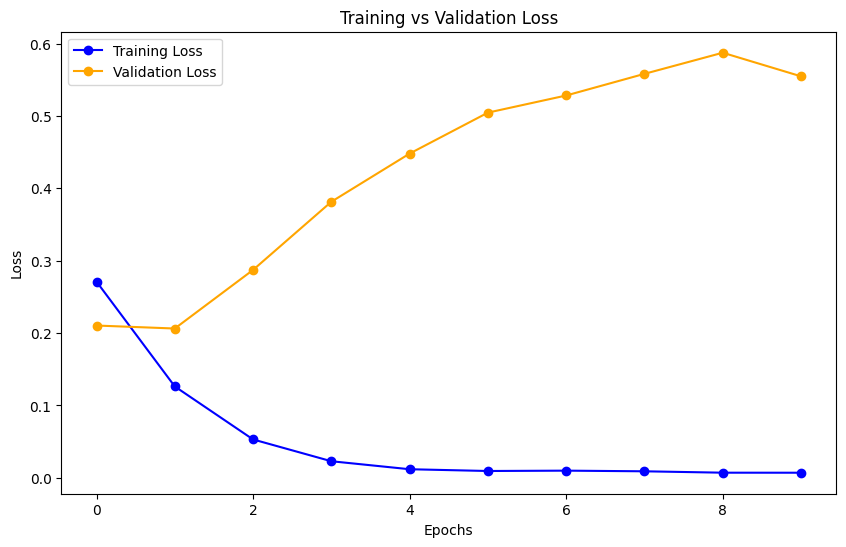

In [ ]:
# Extracting model 3 hyper-parameters
model_num = 3
hyperparams = model_hyperparams[model_num - 1]

# Training the model
model = MultiLabelCNN(act_func=hyperparams["act_func"], lr=hyperparams["lr"], dropout=hyperparams["dropout"], optimiser=hyperparams["optimiser"]).to(device)
print(f"Training started of Model {hyperparams['model_name']}, with parameters:\n{hyperparams}")
start_time = time.time()
train_loss_arr, val_loss_arr = model.train_model(train_images, train_labels, val_images, val_labels, n_epochs)
end_time = time.time()
print("\nTraining Complete, time taken:", end_time - start_time)
exact_match_acc, hamming_acc = model.accuracy(test_images, test_labels)
print(f"Exact Match Accuracy: {round(exact_match_acc * 100, 3)}%, Hamming Accuracy: {round(hamming_acc * 100, 3)}%")

# Plotting loss graph
plot_loss_graph(train_loss_arr, val_loss_arr, f"/content/drive/MyDrive/smai_a4/figures/{hyperparams['task']}/model_{hyperparams['model_name']}_loss.png")

# Saving the model
torch.save(model.state_dict(), f"/content/drive/MyDrive/smai_a4/saved_models/{hyperparams['task']}/model_{hyperparams['model_name']}.pth")
print(f"Saved {hyperparams['task']} model {hyperparams['model_name']}")

## Classification Model 4

Training started of Model 4, with parameters:
{'task': 'multi_label_classification', 'act_func': 'sigmoid', 'lr': 0.01, 'dropout': 0.5, 'optimiser': 'adam', 'model_name': '4'}
Epoch 1/10, iter [1/394], Loss: 0.6908493041992188
Epoch 1/10, iter [2/394], Loss: 0.5210974812507629
Epoch 1/10, iter [3/394], Loss: 0.5562120676040649
Epoch 1/10, iter [4/394], Loss: 0.5094347596168518
Epoch 1/10, iter [5/394], Loss: 0.469321608543396
Epoch 1/10, iter [6/394], Loss: 0.4074430763721466
Epoch 1/10, iter [7/394], Loss: 0.45683732628822327
Epoch 1/10, iter [8/394], Loss: 0.4362231194972992
Epoch 1/10, iter [9/394], Loss: 0.5019351243972778
Epoch 1/10, iter [10/394], Loss: 0.3308723568916321
Epoch 1/10, iter [11/394], Loss: 0.4038217067718506
Epoch 1/10, iter [12/394], Loss: 0.355255663394928
Epoch 1/10, iter [13/394], Loss: 0.3566093444824219
Epoch 1/10, iter [14/394], Loss: 0.3421247899532318
Epoch 1/10, iter [15/394], Loss: 0.31052491068840027
Epoch 1/10, iter [16/394], Loss: 0.35575345158576965


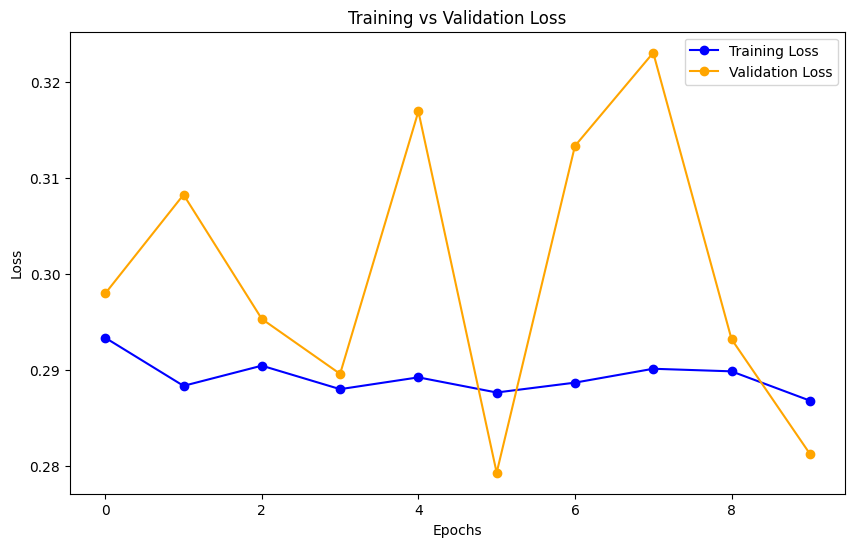

In [ ]:
# Extracting model 4 hyper-parameters
model_num = 4
hyperparams = model_hyperparams[model_num - 1]

# Training the model
model = MultiLabelCNN(act_func=hyperparams["act_func"], lr=hyperparams["lr"], dropout=hyperparams["dropout"], optimiser=hyperparams["optimiser"]).to(device)
print(f"Training started of Model {hyperparams['model_name']}, with parameters:\n{hyperparams}")
start_time = time.time()
train_loss_arr, val_loss_arr = model.train_model(train_images, train_labels, val_images, val_labels, n_epochs)
end_time = time.time()
print("\nTraining Complete, time taken:", end_time - start_time)
exact_match_acc, hamming_acc = model.accuracy(test_images, test_labels)
print(f"Exact Match Accuracy: {round(exact_match_acc * 100, 3)}%, Hamming Accuracy: {round(hamming_acc * 100, 3)}%")

# Plotting loss graph
plot_loss_graph(train_loss_arr, val_loss_arr, f"/content/drive/MyDrive/smai_a4/figures/{hyperparams['task']}/model_{hyperparams['model_name']}_loss.png")

# Saving the model
torch.save(model.state_dict(), f"/content/drive/MyDrive/smai_a4/saved_models/{hyperparams['task']}/model_{hyperparams['model_name']}.pth")
print(f"Saved {hyperparams['task']} model {hyperparams['model_name']}")

## Classification Model 5

Training started of Model 5, with parameters:
{'task': 'multi_label_classification', 'act_func': 'tanh', 'lr': 0.001, 'dropout': 0.5, 'optimiser': 'sgd', 'model_name': '5'}
Epoch 1/10, iter [1/394], Loss: 0.6894134879112244
Epoch 1/10, iter [2/394], Loss: 0.6885614991188049
Epoch 1/10, iter [3/394], Loss: 0.6875417828559875
Epoch 1/10, iter [4/394], Loss: 0.6861739754676819
Epoch 1/10, iter [5/394], Loss: 0.6850168704986572
Epoch 1/10, iter [6/394], Loss: 0.6835278868675232
Epoch 1/10, iter [7/394], Loss: 0.6840241551399231
Epoch 1/10, iter [8/394], Loss: 0.6837828755378723
Epoch 1/10, iter [9/394], Loss: 0.6823928356170654
Epoch 1/10, iter [10/394], Loss: 0.6825056672096252
Epoch 1/10, iter [11/394], Loss: 0.6802724599838257
Epoch 1/10, iter [12/394], Loss: 0.6798188090324402
Epoch 1/10, iter [13/394], Loss: 0.6790521144866943
Epoch 1/10, iter [14/394], Loss: 0.6779029369354248
Epoch 1/10, iter [15/394], Loss: 0.6773947477340698
Epoch 1/10, iter [16/394], Loss: 0.6750785112380981
Epoc

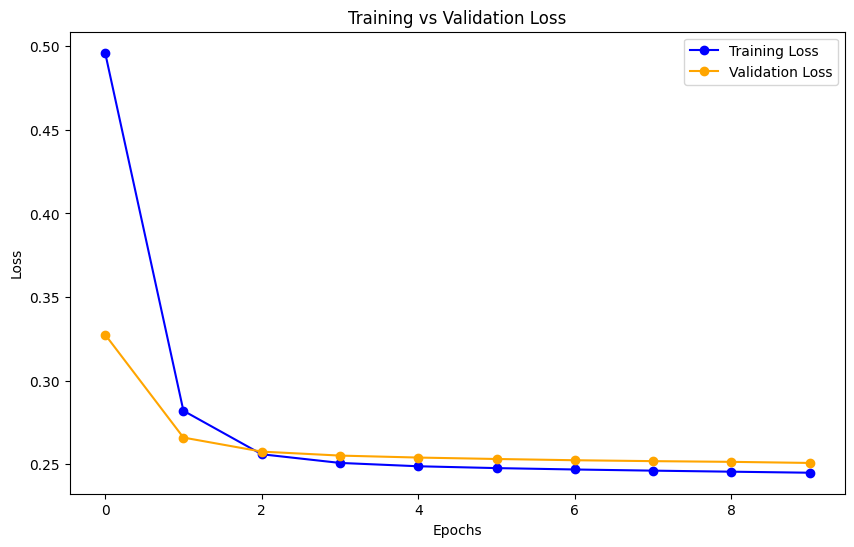

In [ ]:
# Extracting model 5 hyper-parameters
model_num = 5
hyperparams = model_hyperparams[model_num - 1]

# Training the model
model = MultiLabelCNN(act_func=hyperparams["act_func"], lr=hyperparams["lr"], dropout=hyperparams["dropout"], optimiser=hyperparams["optimiser"]).to(device)
print(f"Training started of Model {hyperparams['model_name']}, with parameters:\n{hyperparams}")
start_time = time.time()
train_loss_arr, val_loss_arr = model.train_model(train_images, train_labels, val_images, val_labels, n_epochs)
end_time = time.time()
print("\nTraining Complete, time taken:", end_time - start_time)
exact_match_acc, hamming_acc = model.accuracy(test_images, test_labels)
print(f"Exact Match Accuracy: {round(exact_match_acc * 100, 3)}%, Hamming Accuracy: {round(hamming_acc * 100, 3)}%")

# Plotting loss graph
plot_loss_graph(train_loss_arr, val_loss_arr, f"/content/drive/MyDrive/smai_a4/figures/{hyperparams['task']}/model_{hyperparams['model_name']}_loss.png")

# Saving the model
torch.save(model.state_dict(), f"/content/drive/MyDrive/smai_a4/saved_models/{hyperparams['task']}/model_{hyperparams['model_name']}.pth")
print(f"Saved {hyperparams['task']} model {hyperparams['model_name']}")

In [ ]:
best_model = 5